<a href="https://colab.research.google.com/github/jo1jun/Vision_Transformer/blob/main/ImportedVisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import, device & dtype


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt
import os
import copy

# tensorboard writer
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.long

# tensor 연산을 간편하게 하기 위해 einops moudule import.
# reference & tutorial : http://einops.rocks/pytorch-examples.html
%pip install einops
from einops import reduce, rearrange

# WarmupCosineSchedule 이용
% pip install pytorch_transformers
from pytorch_transformers.optimization import WarmupCosineSchedule

     |████████████████████████████████| 184kB 3.9MB/s 
     |████████████████████████████████| 901kB 26.4MB/s 
     |████████████████████████████████| 1.2MB 36.7MB/s 
     |████████████████████████████████| 133kB 40.6MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 7.5MB 40.8MB/s 
ERROR: botocore 1.20.72 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [3]:
%pip install transformers

from transformers import ViTModel, ViTConfig

     |████████████████████████████████| 2.3MB 3.9MB/s 
     |████████████████████████████████| 3.3MB 37.9MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/')

Mounted at /content/drive


# Simple model

In [5]:
hidden_size = 128
num_hidden_layers = 6
num_attention_heads = 4
intermediate_size = 1024
hidden_act='gelu'
hidden_dropout_prob=0.2
attention_probs_dropout_prob=0.2
image_size=32
patch_size=4
num_channels=3

In [6]:
# Initializing a ViT implemented at VisionTransformer.ipynb
ViTConfig()
configuration = ViTConfig(hidden_size, num_hidden_layers, num_attention_heads, intermediate_size,
                          hidden_act, hidden_dropout_prob, attention_probs_dropout_prob,
                          image_size=image_size, patch_size=patch_size, num_channels=num_channels)

# Initializing a model from the configuration
vit_model = ViTModel(configuration, add_pooling_layer=False)

# Accessing the model configuration
configuration = vit_model.config

print('<<configuration>>\n\n', configuration)

print('<<model>>\n\n', vit_model)

<<configuration>>

 ViTConfig {
  "attention_probs_dropout_prob": 0.2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 128,
  "image_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 4,
  "num_channels": 3,
  "num_hidden_layers": 6,
  "patch_size": 4,
  "transformers_version": "4.6.0"
}

<<model>>

 ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): PatchEmbeddings(
      (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0): ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=128, out_features=128, bias=True)
            (key): Linear(in_features=128, out_features=128, bias=True)
            (value): Linear(in_features=128, out_features=128, bias=True)
        

In [7]:
class ViT(nn.Module):
    def __init__(self, vit_model, d_model, classes):
      super().__init__()
      self.vit_model = vit_model
      # for fine tuning
      self.classifier = nn.Linear(d_model, classes)

    def forward(self, x):
      x = self.vit_model(x)
      output = self.classifier(x.last_hidden_state[:,0,:]) # cls tokken

      return output

# CIFAR10 Dataset & DataLoader

In [8]:
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import sampler

# here we set up a transform to preprocess the data by subtracting the mean RGB value 
# and dividing by the standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

cifar10_train = dset.CIFAR10('dataset', train=True, download=True,
                             transform=transform)

cifar10_val = dset.CIFAR10('dataset', train=True, download=True,
                           transform=transform)

cifar10_test = dset.CIFAR10('dataset', train=False, download=True, 
                            transform=transform)

NUM_TRAIN = 49000

dataloaders = {}
dataloaders['train'] = DataLoader(cifar10_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
dataloaders['val'] = DataLoader(cifar10_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
dataloaders['test'] = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Trainer

In [9]:
def trainer(model_name, model, criterion, optimizer, scheduler, num_epochs=25):

    model.to(device)
    writer = SummaryWriter(f'runs/{model_name}')
    best_model_wts = copy.deepcopy(model.state_dict())
    global_step, best_acc = 0, 0.0
    running_loss, running_acc = {}, {}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss[phase], running_acc[phase] = 0.0, 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss[phase] += loss.item() * inputs.shape[0]
                running_acc[phase] += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            
            running_loss[phase] = running_loss[phase] / (len(dataloaders[phase]) * dataloaders[phase].batch_size)
            running_acc[phase] = running_acc[phase].double() / (len(dataloaders[phase]) * dataloaders[phase].batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, running_loss[phase], running_acc[phase]))

            # deep copy the model
            if phase == 'val' and running_acc[phase] > best_acc:
                best_acc = running_acc[phase]
                best_model_wts = copy.deepcopy(model.state_dict())

        writer.add_scalars(f'{model_name}/loss', {'train' : running_loss['train'], 'val' : running_loss['val']}, global_step)
        writer.add_scalars(f'{model_name}/acc', {'train' : running_acc['train'], 'val' : running_acc['val']}, global_step)
        writer.add_scalar(f'{model_name}/lr', scheduler.get_last_lr()[0], global_step)
        global_step += 1

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    torch.save(model.state_dict(), f'{model_name}.pt')
    print('model saved')

    writer.close()

    return model

# Checker

In [10]:
def checker(loader, model):

    model.to(device)
    model.eval()
    with torch.no_grad():
      correct_num = 0
      for iters, (batch_x, batch_t) in enumerate(loader):

        batch_x = batch_x.to(device)
        batch_t = batch_t.to(device)

        predict = model(batch_x)
        _, predict = predict.max(1)

        correct_num += (predict == batch_t).sum()
        
    return correct_num

# Train

In [11]:
output_dim = 10
num_epochs = 30
learning_rate = 0.001

In [12]:
model_name = 'ViT_CIFAR10_module'
model = ViT(vit_model, hidden_size, output_dim)

In [ ]:
# 새로 학습 시킬 경우 실행.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)
scheduler = WarmupCosineSchedule(optimizer, num_epochs // 5, num_epochs)
model = trainer(model_name, model, criterion, optimizer, scheduler, num_epochs)

Epoch 0/29
----------
train Loss: 2.3990 Acc: 0.1095
val Loss: 2.3474 Acc: 0.0830

Epoch 1/29
----------
train Loss: 1.8406 Acc: 0.3160
val Loss: 1.5692 Acc: 0.3916

Epoch 2/29
----------
train Loss: 1.5996 Acc: 0.4071
val Loss: 1.3741 Acc: 0.4844

Epoch 3/29
----------
train Loss: 1.4312 Acc: 0.4770
val Loss: 1.3095 Acc: 0.5098

Epoch 4/29
----------
train Loss: 1.3568 Acc: 0.5046
val Loss: 1.2536 Acc: 0.5225

Epoch 5/29
----------
train Loss: 1.3104 Acc: 0.5246
val Loss: 1.2157 Acc: 0.5361

Epoch 6/29
----------
train Loss: 1.2697 Acc: 0.5391
val Loss: 1.1374 Acc: 0.5586

Epoch 7/29
----------
train Loss: 1.2032 Acc: 0.5635
val Loss: 1.0752 Acc: 0.5957

Epoch 8/29
----------
train Loss: 1.1493 Acc: 0.5857
val Loss: 1.0562 Acc: 0.5869

Epoch 9/29
----------
train Loss: 1.0965 Acc: 0.6029
val Loss: 0.9878 Acc: 0.6113

Epoch 10/29
----------
train Loss: 1.0468 Acc: 0.6229
val Loss: 0.9970 Acc: 0.6084

Epoch 11/29
----------
train Loss: 1.0033 Acc: 0.6380
val Loss: 0.9813 Acc: 0.6289

Ep

# Model load

In [13]:
model.load_state_dict(torch.load(f'{model_name}.pt'))

<All keys matched successfully>

# Accuracy

In [14]:
correct_num = checker(dataloaders['train'], model)
acc = float(correct_num) / NUM_TRAIN
print('train accuracy %.3f%%' % (acc * 100))

correct_num = checker(dataloaders['val'], model)
acc = float(correct_num) / (50000 - NUM_TRAIN)
print('val accuracy %.3f%%' % (acc * 100))

correct_num = checker(dataloaders['test'], model)
acc = float(correct_num) / len(cifar10_test)
print('test accuracy %.3f%%' % (acc * 100))

train accuracy 86.459%
val accuracy 77.400%
test accuracy 75.600%


# Pretrained Model

In [ ]:
# pretrained vit-base-patch16-224 model
pretrained_vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', add_pooling_layer=False, output_attentions=True)

print('<<model>>\n\m', pretrained_vit_model)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<<model>>
\m ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): PatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0): ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
        )
        (output): ViTOutput(
       

In [ ]:
class PreTrainedViT(nn.Module):
    def __init__(self, pretrained_vit_model, d_model, classes):
      super().__init__()
      self.pretrained_vit_model = pretrained_vit_model
      self.classifier = nn.Linear(d_model, classes)

    def forward(self, x):
      x = self.pretrained_vit_model(x)
      attentions = x.attentions
      output = self.classifier(x.last_hidden_state[:,0,:]) # cls tokken

      return output, attentions

# CIFAR10 Dataset & DataLoader

In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import sampler

# here we set up a transform to preprocess the data by subtracting the mean RGB value 
# and dividing by the standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                T.Resize((224,224)) # image resize 36*36 -> 224*224 for pretrained model
            ])

cifar10_train = dset.CIFAR10('dataset', train=True, download=True,
                             transform=transform)

cifar10_val = dset.CIFAR10('dataset', train=True, download=True,
                           transform=transform)

cifar10_test = dset.CIFAR10('dataset', train=False, download=True, 
                            transform=transform)

NUM_TRAIN = 49000

dataloaders = {}
dataloaders['train'] = DataLoader(cifar10_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
dataloaders['val'] = DataLoader(cifar10_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
dataloaders['test'] = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Fine Tuning

In [ ]:
hidden_size = 768
output_dim = 10
num_epochs = 10
learning_rate = 0.0003 # freeze 하지 않고 fine tuning 하므로 learning_rate 를 작게.

In [ ]:
model_name = 'pretrained_ViT_CIFAR10'
model = PreTrainedViT(pretrained_vit_model, hidden_size, output_dim)

In [ ]:
# 새로 학습 시킬 경우 실행.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)
scheduler = WarmupCosineSchedule(optimizer, num_epochs // 5, num_epochs)
trainer(model_name, model, criterion, optimizer, scheduler, num_epochs)

Epoch 0/9
----------
train Loss: 2.3469 Acc: 0.0015
val Loss: 2.2929 Acc: 0.0039

Epoch 1/9
----------
train Loss: 0.1439 Acc: 0.9693
val Loss: 0.1618 Acc: 0.9268

Epoch 2/9
----------
train Loss: 0.1250 Acc: 0.9602
val Loss: 0.1974 Acc: 0.9141

Epoch 3/9
----------
train Loss: 0.0639 Acc: 0.9789
val Loss: 0.2297 Acc: 0.9072

Epoch 4/9
----------
train Loss: 0.0423 Acc: 0.9863
val Loss: 0.1521 Acc: 0.9375

Epoch 5/9
----------
train Loss: 0.0251 Acc: 0.9916
val Loss: 0.1583 Acc: 0.9375

Epoch 6/9
----------
train Loss: 0.0112 Acc: 0.9959
val Loss: 0.1759 Acc: 0.9355

Epoch 7/9
----------
train Loss: 0.0030 Acc: 0.9986
val Loss: 0.1532 Acc: 0.9424

Epoch 8/9
----------
train Loss: 0.0007 Acc: 0.9994
val Loss: 0.1388 Acc: 0.9424

Epoch 9/9
----------
train Loss: 0.0003 Acc: 0.9995
val Loss: 0.1394 Acc: 0.9434

Best val Acc: 0.943359
model saved


# Model load

In [ ]:
# current working directory 에 model_name.pt file 저장 후 실행.
model.load_state_dict(torch.load(f'{model_name}.pt'))

<All keys matched successfully>

# Accuracy

In [ ]:
correct_num = checker(dataloaders['train'], model)
acc = float(correct_num) / NUM_TRAIN
print('train accuracy %.3f%%' % (acc * 100))

correct_num = checker(dataloaders['val'], model)
acc = float(correct_num) / (50000 - NUM_TRAIN)
print('val accuracy %.3f%%' % (acc * 100))

correct_num = checker(dataloaders['test'], model)
acc = float(correct_num) / len(cifar10_test)
print('test accuracy %.3f%%' % (acc * 100))

train accuracy 100.000%
val accuracy 96.600%
test accuracy 96.840%


# Visualize Attention Maep

Predicted class: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
Predicted class: pelican
Predicted class: tiger, Panthera tigris


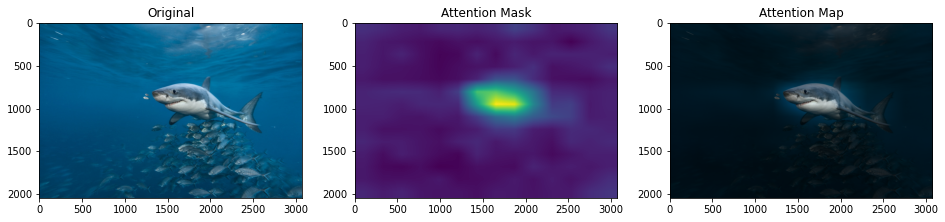

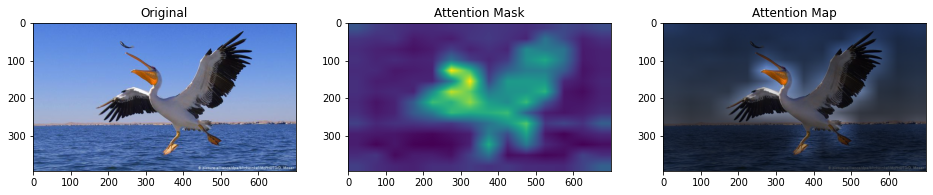

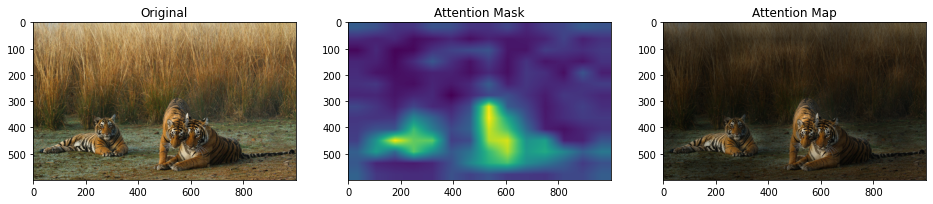

In [22]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
import cv2
from PIL import Image
import requests

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
pretrained_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', output_attentions=True)

# white shark (reference : https://kids.nationalgeographic.com/animals/fish/facts/great-white-shark)
url1 = 'https://i.natgeofe.com/k/d21630fa-3ab9-4e37-adea-c503629e49d4/great_white_smile.jpg'
# pelican (reference : https://www.dw.com/en/theres-more-to-the-pelican-than-a-pouch/g-50613921)
url2 = 'https://static.dw.com/image/50486701_303.jpg'
# tiger (reference : https://www.worldwildlife.org/species/tiger)
url3 = 'https://c402277.ssl.cf1.rackcdn.com/photos/18127/images/story_full_width/Medium_WW251528.jpg?1574444517' 


for url in [url1, url2, url3]:

  image = Image.open(requests.get(url, stream=True).raw)

  inputs = feature_extractor(images=image, return_tensors="pt")
  outputs = pretrained_model(**inputs)
  logits = outputs.logits
  attentions = outputs.attentions
  
  # model predicts one of the 1000 ImageNet classes
  predicted_class_idx = logits.argmax(-1).item()
  print("Predicted class:", pretrained_model.config.id2label[predicted_class_idx])

  # To account for residual connections, we add an identity matrix to the
  # attention matrix and re-normalize the weights.

  att_mat = torch.stack(attentions).squeeze(1)

  # attention 평균
  att_mat = reduce(att_mat, 'b h len1 len2 -> b len1 len2', 'mean')
  im = np.array(image)

  residual_att = torch.eye(att_mat.size(1))
  aug_att_mat = att_mat + residual_att
  aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

  # Recursively multiply the weight matrices
  joint_attentions = torch.zeros(aug_att_mat.size())
  joint_attentions[0] = aug_att_mat[0]

  for n in range(1, aug_att_mat.size(0)):
      joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
      
  # Attention from the output token to the input space.
  v = joint_attentions[-1]
  grid_size = int(np.sqrt(aug_att_mat.size(-1)))
  mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
  mask = cv2.resize(mask / mask.max(), (im.shape[1], im.shape[0]))[..., np.newaxis]
  result = (mask * im).astype("uint8")

  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 16))

  ax1.set_title('Original')
  ax2.set_title('Attention Mask')
  ax3.set_title('Attention Map')
  _ = ax1.imshow(im)
  _ = ax2.imshow(mask.squeeze())
  _ = ax3.imshow(result)